In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt 
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cartoon_data = np.load("/content/drive/MyDrive/CP-302/cartoon_data_centre_crop.npy")
# print_photos(1, cartoon_data)

In [ ]:
def preview_images(cartoon_data) :
  fig = plt.figure(figsize=(8, 8))
  columns = 4
  rows = 4
  for i in range(1, columns*rows +1):
      img = cartoon_data[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
      plt.tick_params(left=False,
                      bottom=False,
                      labelleft=False,
                      labelbottom=False)
  plt.show()
# preview_images(cartoon_data)

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = Conv2D(256, 3, 1, padding='same')
    self.conv_2 = Conv2D(256, 3, 1, padding='same')
    self.norm_1 = BatchNormalization()
    self.norm_2 = BatchNormalization()

In [ ]:
class Generator(tf.keras.Model): 
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = Conv2D(64, 7, strides = 1, padding = 'same')
      self.norm_1 = BatchNormalization()
      self.conv_2 = Conv2D(128, 3, strides = 2, padding = 'same')
      self.conv_3 = Conv2D(128, 3, strides = 1, padding = 'same')
      self.norm_2 = BatchNormalization()
      self.conv_4 = Conv2D(256, 3, strides = 2, padding = 'same')
      self.conv_5 = Conv2D(256, 3, strides = 1, padding = 'same')
      self.norm_3 = BatchNormalization()
      
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = tf.keras.Sequential(residualBlocks)

      self.conv_6 = Conv2DTranspose(128, 3, 2, padding = 'same', output_padding = 1)
      self.conv_7 = Conv2DTranspose(128, 3, 1, padding = 'same')
      self.norm_4 = BatchNormalization()

      self.conv_8 = Conv2DTranspose(64, 3, 2, padding = 'same', output_padding = 1)
      self.conv_9 = Conv2DTranspose(64, 3, 1, padding = 'same')
      self.norm_5 = BatchNormalization()
      
      self.conv_10 = Conv2D(3, 7, 1, padding='same')
      self.act   = tf.keras.layers.ReLU()

    def call(self, x):
      x = self.act(self.norm_1(self.conv_1(x)))
      
      x = self.act(self.norm_2(self.conv_3(self.conv_2(x))))
      x = self.act(self.norm_3(self.conv_5(self.conv_4(x))))
      
      x = self.res(x)
      x = self.act(self.norm_4(self.conv_7(self.conv_6(x))))
      x = self.act(self.norm_5(self.conv_9(self.conv_8(x))))

      x = self.conv_10(x)
      x = tf.sigmoid(x)
      return x
    def model(self):
        x = tf.keras.Input(shape=(256, 256, 3))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


In [ ]:
# sub = Generator()
# sub.model().summary()
# dt1 = tf.random.normal((1,256,256, 3))
# dt2 = dt1.numpy()
# sub(dt)
# dt1

In [ ]:
# batch_size = 16
# img_height = 256
# img_width = 256

# def ceter_crop(image) :
#   width, height = image.size
#   left = (width - img_width)/2
#   top = (height - img_height)/2
#   right = (width + img_width)/2
#   bottom = (height + img_height)/2
#   image = image.crop((left, top, right, bottom))
#   return image


In [ ]:
# import os
# from PIL import ImageFile, Image
# ImageFile.LOAD_TRUNCATED_IMAGES = True
# rootdir = "/content/drive/MyDrive/CP-302/coco_person_parent/coco_person"
# cartoon_data = []
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         filepath = subdir + os.sep + file
#         image = Image.open(filepath)
#         image = ceter_crop(image)
#         image = np.asarray(image)
#         if(image.shape == (256, 256, 3)) :
#           cartoon_data.append(image)

# cartoon_data = np.array(cartoon_data)

In [ ]:
# Image.fromarray(cartoon_data[21])
# cartoon_data[-1].shape
# ds = np.array(cartoon_data[:1000])
# np.save("/content/drive/MyDrive/CP-302/coco_data_centre_crop.npy", cartoon_data)
# ds.shape
# cartoon_data[2000].shape
# for i in range(len(cartoon_data)) : 
#   if cartoon_data[i].shape != (256, 256, 3) :
#     print(i)
# cartoon_data.shape

In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = Conv2D(32, 3, 1, padding='same')
      
     self.conv_2 = Conv2D(64, 3, 2, padding='same')
     self.conv_3 = Conv2D(128, 3, 1, padding='same')
     self.norm_1 = BatchNormalization()
      
     self.conv_4 = Conv2D(128, 3, 2, padding='same')
     self.conv_5 = Conv2D(256, 3, 1, padding='same')
     self.norm_2 = BatchNormalization()
    
     self.conv_6 = Conv2D(256, 3, 1, padding='same')
     self.norm_3 = BatchNormalization()
    
     self.conv_7 = Conv2D(1, 3, 1, padding='same')
     self.act   = tf.keras.layers.LeakyReLU()
     
  def call(self, x):
    x = self.act(self.conv_1(x))
    x = self.act(self.norm_1(self.conv_3(self.act(self.conv_2(x)))))
    x = self.act(self.norm_2(self.conv_5(self.act(self.conv_4(x)))))
    x = self.act(self.norm_3(self.conv_6(x)))
    x = self.conv_7(x)
    x = tf.sigmoid(x)
    return x

  def model(self):
    x = tf.keras.Input(shape=(256, 256, 3))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))
    

In [ ]:
import os
import time
import math
from glob import glob
import random
import matplotlib.pyplot as plt 

class CartoonGAN(object):
    def __init__(self, batch_size = 16, d_lr = 1e-4, g_lr = 1e-4, no_of_epochs = 50, cartoon_ds_path = '', cartoon_smooth_ds_path = '', coco_ds_path = '', sample_dir = ''):
        self.batch_size      =   batch_size
        self.sample_dir      =   sample_dir
        self.update_ratio    =   1
        self.epochs          =   no_of_epochs
        self.cartoon_ds      =   np.load(cartoon_ds_path)
        self.cartoon_smooth_ds      =   np.load(cartoon_smooth_ds_path)
        self.coco_ds      =   np.load(coco_ds_path)
        self.vgg_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top = False)
        self.feature_model = Model(inputs=self.vgg_model.input, outputs=self.vgg_model.get_layer('block4_pool').output)

        self.build_model(d_lr, g_lr)

    def build_model(self, d_lr, g_lr):
        self.G = self.build_generator()
        self.D = self.build_discriminator()
        self.d_opt = tf.keras.optimizers.Adam(d_lr)
        self.g_opt = tf.keras.optimizers.Adam(g_lr)


    def step(self,cartoon_batch, cartoon_smooth_batch, coco_batch, training = True,step = 0):
        with tf.GradientTape() as disc_tape:
            disc_loss = self.discriminator_loss(cartoon_batch, cartoon_smooth_batch, coco_batch)
            if(training):
                gradients_of_discriminator = disc_tape.gradient(disc_loss, self.D.trainable_variables)
                self.d_opt.apply_gradients(zip(gradients_of_discriminator, self.D.trainable_variables))

        for i in range (self.update_ratio):
            with  tf.GradientTape() as gen_tape:
                gen_loss = self.generator_loss(cartoon_batch, cartoon_smooth_batch, coco_batch)
                if(training):
                    gradients_of_generator = gen_tape.gradient(gen_loss, self.G.trainable_variables)
                    self.g_opt.apply_gradients(zip(gradients_of_generator, self.G.trainable_variables))

        return gen_loss, disc_loss              

    def train(self):
        counter = 1
        start_time = time.time()
        preview_ds = self.coco_ds[:batch_size]
        preview_ds = np.array(preview_ds).astype(np.float32)

        for epoch in range(self.epochs):
            # np.random.shuffle(self.data)
            batch_idxs = len(self.cartoon_ds) // self.batch_size

            for idx in range(0, batch_idxs):
                cartoon_batch = self.cartoon_ds[idx*self.batch_size:(idx+1)*self.batch_size]
                coco_batch = self.coco_ds[idx*self.batch_size:(idx+1)*self.batch_size]
                cartoon_smooth_batch = self.cartoon_smooth_ds[idx*self.batch_size:(idx+1)*self.batch_size]

                cartoon_batch = np.array(cartoon_batch).astype(np.float32)
                coco_batch = np.array(coco_batch).astype(np.float32)
                cartoon_smooth_batch = np.array(cartoon_smooth_batch).astype(np.float32)
                g_loss, d_loss = self.step(cartoon_batch, cartoon_smooth_batch, coco_batch,step=idx)
                counter += 1
                if np.mod(counter, 10) == 0:
                    print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.4f, g_loss: %.4f" \
                        % (epoch, idx, batch_idxs, time.time()-start_time, d_loss, g_loss))

                # if np.mod(counter, 20) == 0:
                #     G_samples = self.G(preview_ds, training = False)
                #     path = '{}/train_{:02d}_{:04d}_{:2.4f}_{:2.4f}.jpg'.format(self.sample_dir, epoch, idx,d_loss, g_loss)                
                #     preview_images(G_samples)
                #     g_loss, d_loss = self.step(cartoon_batch, cartoon_smooth_batch, coco_batch,training = False)
                #     print("[Sample] d_loss: %.8f, g_loss: %.8f" % (d_loss, g_loss)) 

    def build_discriminator(self): 
        return Discriminator()
        
    def build_generator(self):
        return Generator()
    
    def adversial_loss(self, D_of_cartoon, D_of_cartoon_smoothed, D_of_G_of_image):
      bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
      ones = tf.ones_like(D_of_cartoon)
      zeros = tf.zeros_like(D_of_cartoon)

      d_loss_cartoon = bce_loss(ones, D_of_cartoon)
      d_loss_cartoon_smoothed  = bce_loss(zeros, D_of_cartoon_smoothed)
      d_loss_generated_input  = bce_loss(zeros, D_of_G_of_image)

      d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input
      return d_loss


    def content_loss(self, generator_output, generator_input) :
      return tf.norm(self.feature_model(generator_output) - self.feature_model(generator_input), ord = 1)
    
    def generator_loss(self, cartoon_batch, cartoon_smooth_batch, images_batch) :
      D_of_cartoon = self.D(cartoon_batch, training = True)
      D_of_cartoon_smoothed = self.D(cartoon_smooth_batch, training = True)
      D_of_G_of_image = self.D(self.G(images_batch, training = True), training = True)
      return self.adversial_loss(D_of_cartoon, D_of_cartoon_smoothed, D_of_G_of_image)
              

    def discriminator_loss(self, cartoon_batch, cartoon_smooth_batch, images_batch) :
      D_of_cartoon = self.D(cartoon_batch, training = True)
      D_of_cartoon_smoothed = self.D(cartoon_smooth_batch, training = True)
      D_of_G_of_image = self.D(self.G(images_batch, training = True), training = True)
      return self.adversial_loss(D_of_cartoon, D_of_cartoon_smoothed, D_of_G_of_image)

    


if __name__ == '__main__':
    batch_size = 64
    n_component = 9
    n_class = 5
    geometric_dim=4
    GAN = CartoonGAN(cartoon_ds_path = '/content/drive/MyDrive/CP-302/cartoon_data_centre_crop.npy', 
                     cartoon_smooth_ds_path = '/content/drive/MyDrive/CP-302/cartoonsmooth_data_centre_crop.npy', 
                     coco_ds_path = '/content/drive/MyDrive/CP-302/coco_data_centre_crop.npy', 
                     sample_dir = '/content/drive/MyDrive/CP-302/Samples/test_samples')
    
    

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
GAN.train()

In [ ]:
# cartoon_data = np.load("/content/drive/MyDrive/CP-302/cartoon_data_centre_crop.npy")
# print_photos(1, cartoon_data)
ds = GAN.coco_ds[:16]
ds = np.array(ds).astype(np.float32)
pre = GAN.G(ds)
# preview_images(pre)

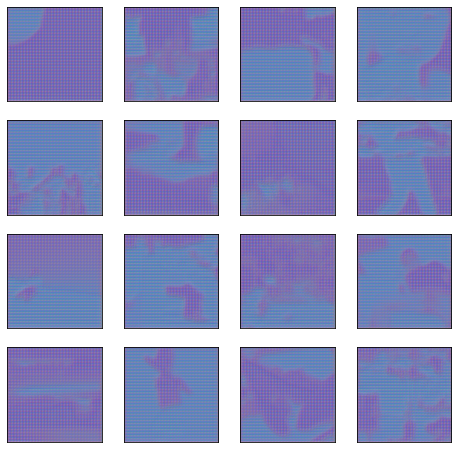

In [ ]:
preview_images(pre)


In [ ]:
coco_ds = np.load("/content/drive/MyDrive/CP-302/coco_data_centre_crop.npy")


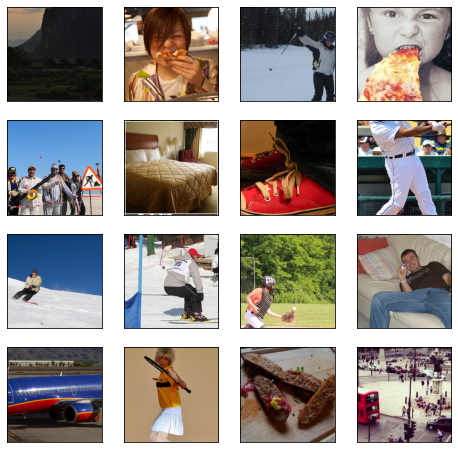

In [ ]:

ds = coco_ds[:16]
# ds = np.array(ds).astype(np.float32)
preview_images(ds)
